In [28]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
import statistics

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split



In [2]:
#Checking for tensorflow-GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [3]:
#Unzipping Attack and Validation folders

# Unzip Attack Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Attack_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Attack File')
    
# Unzip Validation Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Validation_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Validation File')
    
# Unzip Training Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Training_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Training File')

# list holding normal training data
train_normal_data = [] 



from pathlib import Path 
# list that holds attack vectors
train_attack_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Attack_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_attack_data.append(string_split_data)
    

for i in range(len(train_attack_data)):
  for j in range(len(train_attack_data[i])):
    train_attack_data[i][j] = int(train_attack_data[i][j])

from pathlib import Path 
# list that holds validation vectors
train_validation_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Validation_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_validation_data.append(string_split_data)
    

# list that holds training vectors
train_normal_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Training_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_normal_data.append(string_split_data)
    

for i in range(len(train_normal_data)):
  for j in range(len(train_normal_data[i])):
    train_normal_data[i][j] = int(train_normal_data[i][j])
print("Normal Data     --->  train_normal_data")
print("Attack Data     --->  train_attack_data")
print("Validation Data --->  train_validation_data")


Unizipped Attack File
Unizipped Validation File
Unizipped Training File
Normal Data     --->  train_normal_data
Attack Data     --->  train_attack_data
Validation Data --->  train_validation_data


In [4]:
#Generating one hot vectors
dict = {}
# Feature size
vocab_size = 341

for x in range(vocab_size):
    arr=[]
    arr = [0 for i in range(vocab_size)] 
    arr[x] = 1
    dict[x] = arr

In [5]:
#Sequence size
n = 15
#N-Gram
m = 15

In [6]:
# This method receives a request array and returns one hot encoded version of that array
def generate_one_hot(request):
    temp = []
    for sys_call in request:
        temp.append(dict[int(sys_call)])
    return temp

# This method recevies a request array, start and  end of the request and populates x_train and y_train
# with returned one hot version from the generate_trainSet method
def split_request(source, target, request, start, end):
    while(len(request)-start >= n+m):
        source.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        target.append(generate_one_hot(request[start:end]))
    

In [7]:
x_train = []
y_train = [] 

# Populating x_train and y_train with sources and targets
for i in range(len(train_normal_data)):
    split_request(x_train, y_train, train_normal_data[i],0,n)

In [8]:
x_train = x_train[0:19000]
y_train = y_train[0:19000]

In [9]:
# Converting x_train and y_train into np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
len(x_train)

19000

In [11]:
# split test data into training and testing sets
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.10,random_state=4)

In [12]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(17100, 15, 341)
(1900, 15, 341)


In [13]:
n_timesteps_in = n
n_features = vocab_size
latentSpaceDimension = 200


In [14]:
def create_hard_coded_decoder_input_model(batch_size):
  # The first part is encoder
  encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
  encoder_lstm = LSTM(latentSpaceDimension, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
  
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the decoder layers
  decoder_inputs = Input(shape=(1, n_features))
  decoder_lstm = LSTM(latentSpaceDimension, return_sequences=True, 
                      return_state=True, name='decoder_lstm')
  decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []
  # Prepare decoder input data that just contains the start character 0
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  decoder_input_data = np.zeros((batch_size, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 #
  
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  inputs = decoder_input_data
  # decoder will only process one timestep at a time.
  for _ in range(n_timesteps_in):
      # Run the decoder on one timestep
      outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  # Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  # Define and compile model 
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [15]:
batch_size = 100
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
#model_encoder_decoder.summary()

In [16]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=batch_size, patience=5,verbose=0):
	# patient early stopping
	es = EarlyStopping(monitor='val_accuracy', mode='max',  verbose=1, patience=patience)
	#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_accuracy, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	


In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.verbose= verbose

  def call(self, query, values):
    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
    return context_vector, attention_weights


In [18]:
history = model_encoder_decoder.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=500)

Epoch 1/500
171/171 [==============================] - 30s 33ms/step - loss: 2.5328 - accuracy: 0.3330
Epoch 2/500
171/171 [==============================] - 5s 32ms/step - loss: 1.9763 - accuracy: 0.4303
Epoch 3/500
171/171 [==============================] - 5s 32ms/step - loss: 1.8632 - accuracy: 0.4430
Epoch 4/500
171/171 [==============================] - 5s 32ms/step - loss: 1.8078 - accuracy: 0.4480
Epoch 5/500
171/171 [==============================] - 6s 34ms/step - loss: 1.7690 - accuracy: 0.4534
Epoch 6/500
171/171 [==============================] - 6s 36ms/step - loss: 1.7405 - accuracy: 0.4580
Epoch 7/500
171/171 [==============================] - 6s 35ms/step - loss: 1.7189 - accuracy: 0.4603
Epoch 8/500
171/171 [==============================] - 6s 37ms/step - loss: 1.6971 - accuracy: 0.4644
Epoch 9/500
171/171 [==============================] - 7s 41ms/step - loss: 1.6765 - accuracy: 0.4678
Epoch 10/500
171/171 [==============================] - 7s 42ms/step - loss: 1.65

171/171 [==============================] - 6s 36ms/step - loss: 1.0034 - accuracy: 0.6574
Epoch 80/500
171/171 [==============================] - 6s 35ms/step - loss: 1.0017 - accuracy: 0.6578
Epoch 81/500
171/171 [==============================] - 6s 37ms/step - loss: 0.9959 - accuracy: 0.6595
Epoch 82/500
171/171 [==============================] - 6s 37ms/step - loss: 0.9925 - accuracy: 0.6604
Epoch 83/500
171/171 [==============================] - 6s 35ms/step - loss: 0.9861 - accuracy: 0.6623
Epoch 84/500
171/171 [==============================] - 6s 36ms/step - loss: 0.9815 - accuracy: 0.6636
Epoch 85/500
171/171 [==============================] - 6s 35ms/step - loss: 0.9759 - accuracy: 0.6648
Epoch 86/500
171/171 [==============================] - 6s 35ms/step - loss: 0.9737 - accuracy: 0.6666
Epoch 87/500
171/171 [==============================] - 6s 37ms/step - loss: 0.9654 - accuracy: 0.6688
Epoch 88/500
171/171 [==============================] - 6s 36ms/step - loss: 0.9640 - 

171/171 [==============================] - 7s 41ms/step - loss: 0.7198 - accuracy: 0.7490
Epoch 159/500
171/171 [==============================] - 7s 41ms/step - loss: 0.7181 - accuracy: 0.7492
Epoch 160/500
171/171 [==============================] - 7s 41ms/step - loss: 0.7163 - accuracy: 0.7492
Epoch 161/500
171/171 [==============================] - 6s 38ms/step - loss: 0.7152 - accuracy: 0.7497
Epoch 162/500
171/171 [==============================] - 6s 38ms/step - loss: 0.7138 - accuracy: 0.7513
Epoch 163/500
171/171 [==============================] - 6s 37ms/step - loss: 0.7107 - accuracy: 0.7516
Epoch 164/500
171/171 [==============================] - 6s 36ms/step - loss: 0.7061 - accuracy: 0.7537
Epoch 165/500
171/171 [==============================] - 6s 36ms/step - loss: 0.7015 - accuracy: 0.7553
Epoch 166/500
171/171 [==============================] - 6s 36ms/step - loss: 0.7003 - accuracy: 0.7551
Epoch 167/500
171/171 [==============================] - 8s 45ms/step - loss: 

171/171 [==============================] - 6s 36ms/step - loss: 0.5758 - accuracy: 0.8016
Epoch 237/500
171/171 [==============================] - 6s 36ms/step - loss: 0.5749 - accuracy: 0.8012
Epoch 238/500
171/171 [==============================] - 8s 46ms/step - loss: 0.5746 - accuracy: 0.8024
Epoch 239/500
171/171 [==============================] - 6s 37ms/step - loss: 0.5731 - accuracy: 0.8015
Epoch 240/500
171/171 [==============================] - 6s 36ms/step - loss: 0.5716 - accuracy: 0.8024
Epoch 241/500
171/171 [==============================] - 6s 36ms/step - loss: 0.5711 - accuracy: 0.8029
Epoch 242/500
171/171 [==============================] - 7s 39ms/step - loss: 0.5702 - accuracy: 0.8033
Epoch 243/500
171/171 [==============================] - 6s 37ms/step - loss: 0.5661 - accuracy: 0.8041
Epoch 244/500
171/171 [==============================] - 6s 37ms/step - loss: 0.5636 - accuracy: 0.8057
Epoch 245/500
171/171 [==============================] - 6s 37ms/step - loss: 

171/171 [==============================] - 6s 35ms/step - loss: 0.4936 - accuracy: 0.8313
Epoch 315/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4914 - accuracy: 0.8326
Epoch 316/500
171/171 [==============================] - 6s 37ms/step - loss: 0.4964 - accuracy: 0.8301
Epoch 317/500
171/171 [==============================] - 6s 37ms/step - loss: 0.4937 - accuracy: 0.8309
Epoch 318/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4895 - accuracy: 0.8330
Epoch 319/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4900 - accuracy: 0.8320
Epoch 320/500
171/171 [==============================] - 6s 37ms/step - loss: 0.4911 - accuracy: 0.8321
Epoch 321/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4900 - accuracy: 0.8325
Epoch 322/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4883 - accuracy: 0.8341
Epoch 323/500
171/171 [==============================] - 6s 35ms/step - loss: 

171/171 [==============================] - 6s 36ms/step - loss: 0.4424 - accuracy: 0.8514
Epoch 393/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4450 - accuracy: 0.8500
Epoch 394/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4452 - accuracy: 0.8493
Epoch 395/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4425 - accuracy: 0.8500
Epoch 396/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4464 - accuracy: 0.8482
Epoch 397/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4440 - accuracy: 0.8502
Epoch 398/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4417 - accuracy: 0.8510
Epoch 399/500
171/171 [==============================] - 6s 34ms/step - loss: 0.4374 - accuracy: 0.8525
Epoch 400/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4375 - accuracy: 0.8518
Epoch 401/500
171/171 [==============================] - 6s 35ms/step - loss: 

171/171 [==============================] - 6s 34ms/step - loss: 0.4070 - accuracy: 0.8624
Epoch 471/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4087 - accuracy: 0.8633
Epoch 472/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4072 - accuracy: 0.8638
Epoch 473/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4078 - accuracy: 0.8635
Epoch 474/500
171/171 [==============================] - 6s 34ms/step - loss: 0.4074 - accuracy: 0.8638
Epoch 475/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4070 - accuracy: 0.8635
Epoch 476/500
171/171 [==============================] - 6s 35ms/step - loss: 0.4074 - accuracy: 0.8634
Epoch 477/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4072 - accuracy: 0.8632
Epoch 478/500
171/171 [==============================] - 6s 36ms/step - loss: 0.4133 - accuracy: 0.8618
Epoch 479/500
171/171 [==============================] - 6s 36ms/step - loss: 

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


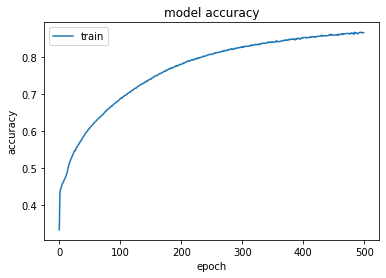

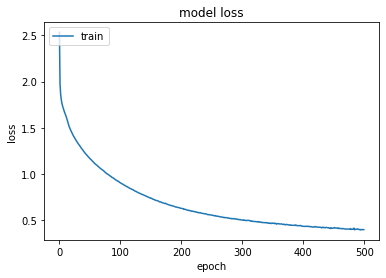

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
# Receives one hot represetation and returns index where value = 1
def one_hot_decode(arr):
    for index,num in enumerate(arr):
        if num == 1:
            return index
        
# Receives an array to append to and a 3D-array that is one hot encoded      
def decode(arr, three_d_array):
    for seq in three_d_array:
        temp = []
        for one_hot in seq:
            temp.append(one_hot_decode(one_hot))
        arr.append(temp)


In [64]:
# Decodes prediction done by LSTM and stores it in arr.
def prediction_decode(arr, prediction):
    for seq in prediction:
        predict_temp = []
        for one_hot in seq:
            predict_temp.append(argmax(one_hot))
        arr.append(predict_temp)
    
    

In [82]:
# perfect match
from nltk.translate.bleu_score import sentence_bleu
def calc_belu(target, prediction):
    reference = []
    candidate = []
    reference.append(target)
    candidate.extend(prediction)
    return sentence_bleu(reference, candidate, weights=(0.3,0.7))

In [83]:
sources = []
decode(sources, x_test[0:100])

targets = []
decode(targets, y_test[0:100])

predictions = []
prediction_decode(predictions, model_encoder_decoder.predict( x_test[0:100], batch_size = batch_size))


In [84]:
for i in range(batch_size):
    print(f"Source: {sources[i]}")
    print(f"Target: {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("---------------------------------------------------")

Source: [6, 63, 6, 11, 5, 192, 6, 192, 192, 125, 125, 125, 125, 54, 45]
Target: [197, 197, 195, 174, 174, 3, 6, 91, 195, 3, 6, 91, 5, 45, 3]
Prediction: [5, 3, 197, 197, 195, 3, 195, 195, 3, 6, 3, 3, 3, 3, 3]
---------------------------------------------------
Source: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Target: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Prediction: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
---------------------------------------------------
Source: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Target: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4]
Prediction: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
---------------------------------------------------
Source: [175, 175, 45, 175, 175, 175, 175, 45, 45, 45, 45, 45, 175, 3, 175]
Target: [175, 45, 45, 174, 174, 175, 120, 175, 3, 7, 7, 175, 175, 175, 120]
Prediction: [175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175]
---------------------------------------------------
Source: [19

In [85]:
temp_score = []
for i in range(batch_size):
    temp_score.append(calc_belu(targets[i],predictions[i]))

In [86]:
print(statistics.mean(temp_score))

0.6665087973491287


In [56]:
# VALIDATION

In [25]:
for i in range(len(train_validation_data)):
    for j in range(len(train_validation_data[i])):
        train_validation_data[i][j] = int(train_validation_data[i][j])

In [30]:
def calc_request_belu_score(request,start,end):
    request_sources = []
    request_targets = []
    request_prediction = []
    request_scores= []
    
    decoded_request_targets = []
    
    while(len(request)-start >= n+m):
        request_sources.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        request_targets.append(request[start:end])
    
    i = 1
    while(i < len(request_sources)):
        prediction_decode( request_prediction, model_encoder_decoder.predict(request_sources[i-1:i]))
        i += 1
    
    for i in range(len(request_prediction)):
        request_scores.append(calc_belu(request_targets[i],request_prediction[i]))
        
    print(request_scores)
    return request_scores

In [31]:
means = []

for i in range(len(train_validation_data)-2300-1000):
    print(f'{i+1}/{len(train_validation_data)-2300-1000}')
    print('-------------------------------------------------------------------')
    means.append(statistics.mean(calc_request_belu_score(train_validation_data[i],0,n)))

1/1072
-------------------------------------------------------------------


InvalidArgumentError: Graph execution error:

Invalid input_h shape: [1,1,200] [1,100,200]
	 [[{{node CudnnRNN}}]]
	 [[model_encoder_decoder/decoder_lstm/PartitionedCall]] [Op:__inference_predict_function_383201]

In [ ]:
attack_means = []

for i in range((len(train_attack_data))):
    print(f'{i+1}/{len(train_attack_data)}')
    print('-------------------------------------------------------------------')
    attack_means.append(statistics.mean(calc_request_belu_score(train_attack_data[i],0,n)))

In [ ]:
print(statistics.mean(means))
print(statistics.mean(attack_means))